<a href="https://colab.research.google.com/github/Is-Dani/DeteccionSomnolenciaIA3/blob/main/tf_lite.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive') 

Mounted at /content/drive


In [47]:
# ! git clone https://github.com/jjrodcast/MaskDetector-YoloV4
# %cd /content/drive/MyDrive/IA3
%cd ../

/content


In [2]:
!cp -R '/content/drive/MyDrive/IA3/utils' '/content'

In [3]:
import sys
# sys.path.append('MaskDetector-YoloV4')
from utils.predict import Predictor
from utils.model_utils import draw_bbox
import matplotlib.pyplot as plt
import cv2

In [4]:
!cp -R '/content/drive/MyDrive/Colab Notebooks/yolov4-tiny-416' '/content'

In [5]:
CONFIDENCE = 0.30 # Porcentage de confianza del detector de rostros
classes = ['face'] # Clases de la capa final

In [24]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.python.saved_model import tag_constants
from PIL import Image
from utils.model_utils import draw_bbox

class PredictorMio:
    # Modificado de: https://github.com/hunglc007/tensorflow-yolov4-tflite/blob/master/detect.py
    def __init__(self, model_path, classes, confidence):
        self.model_path = model_path
        self.classes = classes
        self.box_colors = [(255,128,0),(0,255,0),(255,0,0)]
        self.confidence = confidence
        self.model = self.__load_model()

    def __load_model(self):
        return tf.saved_model.load(self.model_path, tags=[tag_constants.SERVING])

    def predict(self, img_path, img_size):
        """
        Función que permite realizar las predicciones

        Parameters
        ----------
        img_path : Ruta de la imagen a predecir.
        img_size : Tupla de la dimensión de la imagen.
        """
        # Read oiginal image
        original_image = cv2.imread(img_path)
        original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

        # Resize & Scale image
        image_scaled = cv2.resize(original_image, img_size)
        image_scaled = image_scaled / 255.
        
        # Expand first dimension
        images = np.expand_dims(image_scaled, axis=0).astype(np.float32)

        # We are not using tflite, so there is no condition
        inference = self.model.signatures['serving_default']
        image_batch = tf.constant(images)
        prediction_bboxes = inference(image_batch)

        # Obtenemos los boxes y confidences
        boxes = None
        confidences = None
        for key, value in prediction_bboxes.items():
            boxes = value[:,:,0:4]
            confidences = value[:,:,4:]

        # Non-maximum supression
        boxes, scores, classes, valid_detections = tf.image.combined_non_max_suppression(
            boxes = tf.reshape(boxes, (tf.shape(boxes)[0], -1, 1, 4)),
            scores = tf.reshape(confidences,(tf.shape(confidences)[0], -1, tf.shape(confidences)[-1])),
            max_output_size_per_class=50,
            max_total_size=50,
            iou_threshold=0.45,
            score_threshold=self.confidence) #score_threshold=0.25

        # Obtenemos las predicciones
        predictions = [boxes.numpy(), scores.numpy(), classes.numpy(), valid_detections.numpy()]

        # Generamos la imagen con los bounding boxes
        image = draw_bbox(original_image, predictions, self.classes, self.box_colors)
        image = Image.fromarray(image.astype(np.uint8))
        image = cv2.cvtColor(np.array(image), cv2.COLOR_BGR2RGB)
        
        return image, boxes.numpy()

In [25]:
predictor = PredictorMio(model_path='/content/yolov4-tiny-416', classes=classes, confidence=CONFIDENCE)

In [43]:
pred, box= predictor.predict(img_path='/content/drive/MyDrive/IA3/pruebas/82981-CARA.jpg', img_size=(416,416))
image_h, image_w, _ = pred.shape
cuadrado = box[0][0]

print(cuadrado)
a = cuadrado[0]*image_h
b = cuadrado[1]*image_h
c = cuadrado[2]*image_w
d = cuadrado[3]*image_w
print(a, b, c, d)


[0.01694529 0.34866583 0.8118266  0.7397337 ]
6.778115779161453 139.46633338928223 535.8055472373962 488.22423934936523


In [45]:
import dlib
cuadrado2 =dlib.rectangle(int(b), int(a), int(c), int(d))
print(cuadrado2)

# [[(238, 197) (610, 569)]]
# [(308, 108) (566, 366)]

[(139, 6) (535, 488)]


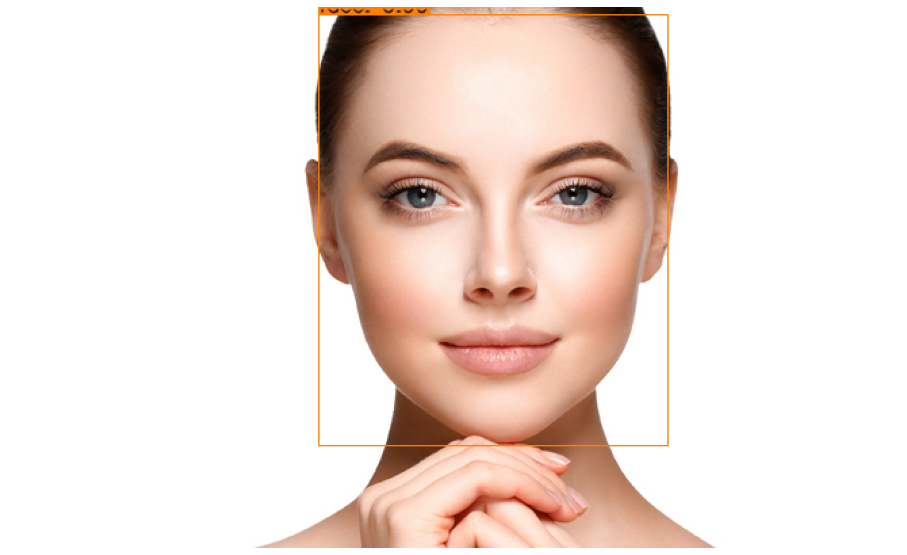

In [47]:
plt.figure(figsize=(16,16))
plt.imshow(cv2.cvtColor(pred, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

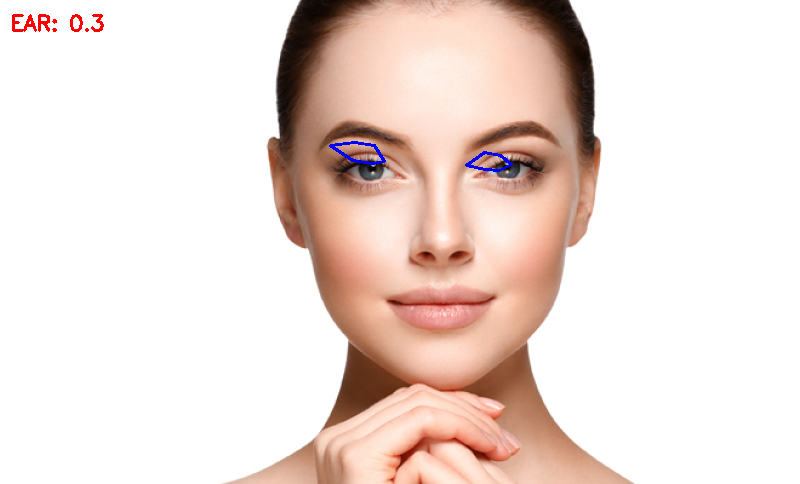

-1

In [46]:
import cv2
import dlib
import imutils
from imutils import face_utils
from scipy.spatial import distance as dist
from google.colab.patches import cv2_imshow


#Global Configuration Variables
FACIAL_LANDMARK_PREDICTOR = "/content/drive/MyDrive/IA3/dlib/shape_predictor_68_face_landmarks.dat"  
# path to dlib's pre-trained facial landmark predictor
MINIMUM_EAR = 0.2    # Minimum EAR for both the eyes to mark the eyes as open


#Initializations
# faceDetector = dlib.get_frontal_face_detector()
landmarkFinder = dlib.shape_predictor(FACIAL_LANDMARK_PREDICTOR)
# webcamFeed = cv2.VideoCapture(0)  
# faceDetector = predictor    
# print(faceDetector) 
# # dlib's HOG based face detector
# # dlib's landmark finder/predcitor inside detected face

# # Finding landmark id for left and right eyes
(leftEyeStart, leftEyeEnd) = face_utils.FACIAL_LANDMARKS_IDXS["left_eye"]
(rightEyeStart, rightEyeEnd) = face_utils.FACIAL_LANDMARKS_IDXS["right_eye"]



def eye_aspect_ratio(eye):
    p2_minus_p6 = dist.euclidean(eye[1], eye[5])
    p3_minus_p5 = dist.euclidean(eye[2], eye[4])
    p1_minus_p4 = dist.euclidean(eye[0], eye[3])
    ear = (p2_minus_p6 + p3_minus_p5) / (2.0 * p1_minus_p4)
    return ear


image = cv2.imread("/content/drive/MyDrive/IA3/pruebas/82981-CARA.jpg")
image = imutils.resize(image, width=800)
grayImage = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# faces = faceDetector(grayImage, 0)
# print(faces)
face = cuadrado2

faceLandmarks = landmarkFinder(grayImage, face)
faceLandmarks = face_utils.shape_to_np(faceLandmarks)

leftEye = faceLandmarks[leftEyeStart:leftEyeEnd]
rightEye = faceLandmarks[rightEyeStart:rightEyeEnd]

leftEAR = eye_aspect_ratio(leftEye)
rightEAR = eye_aspect_ratio(rightEye)

ear = (leftEAR + rightEAR) / 2.0

leftEyeHull = cv2.convexHull(leftEye)
rightEyeHull = cv2.convexHull(rightEye)

cv2.drawContours(image, [leftEyeHull], -1, (255, 0, 0), 2)
cv2.drawContours(image, [rightEyeHull], -1, (255, 0, 0), 2)
    
cv2.putText(image, "EAR: {}".format(round(ear, 1)), (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

if ear < MINIMUM_EAR:
  cv2.putText(image, "Drowsiness", (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

cv2_imshow( image)
cv2.waitKey(0)

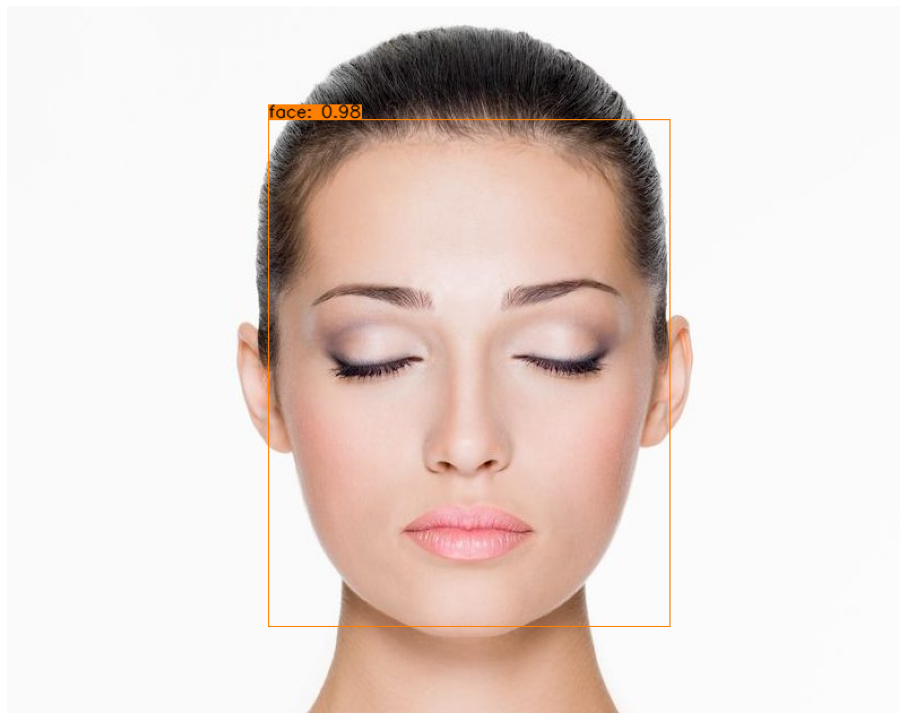

In [41]:
plt.figure(figsize=(16,16))
plt.imshow(cv2.cvtColor(pred, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

[(308, 108) (566, 366)]


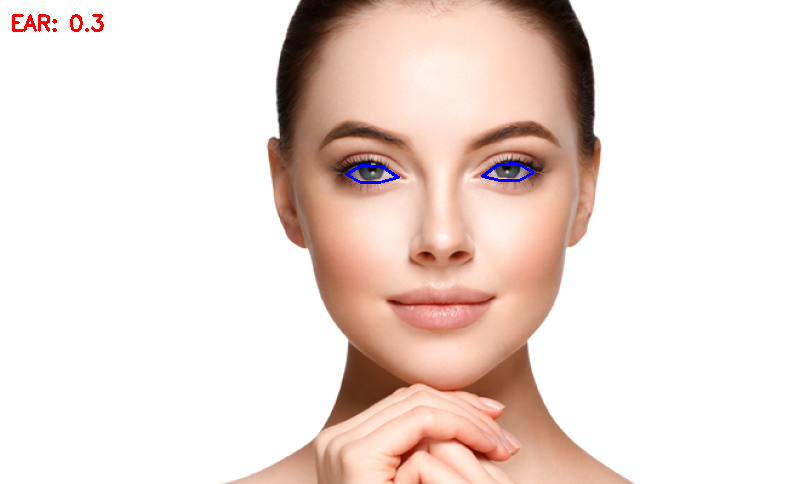

-1

In [60]:
import cv2
import dlib
import imutils
from imutils import face_utils
from scipy.spatial import distance as dist
from google.colab.patches import cv2_imshow


#Global Configuration Variables
FACIAL_LANDMARK_PREDICTOR = "/content/drive/MyDrive/IA3/dlib/shape_predictor_68_face_landmarks.dat"  
# path to dlib's pre-trained facial landmark predictor
MINIMUM_EAR = 0.2    # Minimum EAR for both the eyes to mark the eyes as open


#Initializations
faceDetector = dlib.get_frontal_face_detector()
landmarkFinder = dlib.shape_predictor(FACIAL_LANDMARK_PREDICTOR)
# webcamFeed = cv2.VideoCapture(0)  
# faceDetector = predictor    
# print(faceDetector) 
# # dlib's HOG based face detector
# # dlib's landmark finder/predcitor inside detected face

# # Finding landmark id for left and right eyes
(leftEyeStart, leftEyeEnd) = face_utils.FACIAL_LANDMARKS_IDXS["left_eye"]
(rightEyeStart, rightEyeEnd) = face_utils.FACIAL_LANDMARKS_IDXS["right_eye"]



def eye_aspect_ratio(eye):
    p2_minus_p6 = dist.euclidean(eye[1], eye[5])
    p3_minus_p5 = dist.euclidean(eye[2], eye[4])
    p1_minus_p4 = dist.euclidean(eye[0], eye[3])
    ear = (p2_minus_p6 + p3_minus_p5) / (2.0 * p1_minus_p4)
    return ear


image = cv2.imread("/content/drive/MyDrive/IA3/pruebas/82981-CARA.jpg")
image_h, image_w, c= image.shape
image = imutils.resize(image, width=800)
grayImage = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# rect= dlib.rectangle()

faces = faceDetector(grayImage, 0)
# faces = predictor.predict(grayImage, img_size=(192,192))

for face in faces:
   

    faceLandmarks = landmarkFinder(grayImage, face)
    faceLandmarks = face_utils.shape_to_np(faceLandmarks)

    leftEye = faceLandmarks[leftEyeStart:leftEyeEnd]
    rightEye = faceLandmarks[rightEyeStart:rightEyeEnd]

    leftEAR = eye_aspect_ratio(leftEye)
    rightEAR = eye_aspect_ratio(rightEye)

    ear = (leftEAR + rightEAR) / 2.0

    leftEyeHull = cv2.convexHull(leftEye)
    rightEyeHull = cv2.convexHull(rightEye)

    cv2.drawContours(image, [leftEyeHull], -1, (255, 0, 0), 2)
    cv2.drawContours(image, [rightEyeHull], -1, (255, 0, 0), 2)
    
    cv2.putText(image, "EAR: {}".format(round(ear, 1)), (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

    if ear < MINIMUM_EAR:
        cv2.putText(image, "Drowsiness", (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
    print(face)

cv2_imshow( image)
cv2.waitKey(0)

In [169]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename


In [2]:
 
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data
 
# start streaming video from webcam
take_photo()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0 
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break
    # convert JS response to OpenCV Image
    frame = js_to_image(js_reply["img"])
  
    # # create transparent overlay for bounding box
    # bbox_array = np.zeros([480,640,4], dtype=np.uint8)
 
    # # call our darknet helper on video frame
    # detections, width_ratio, height_ratio, Milandmarks = darknet_helper(frame, width, height)
    # # x = Milandmarks.part(17).x
    # # y = Milandmarks.part(17).y 
    # # loop through detections and draw them on transparent overlay image
    # for label, confidence, bbox in detections:
    #   left, top, right, bottom = bbox2points(bbox)
    #   left, top, right, bottom = int(left * width_ratio), int(top * height_ratio), int(right * width_ratio), int(bottom * height_ratio)
    #   bbox_array = cv2.rectangle(bbox_array, (left, top), (right, bottom), class_colors[label], 2)
    #   for n in range(36, 68):
    #     x = Milandmarks.part(n).x
    #     y = Milandmarks.part(n).y
    #     # bbox_array = cv2.circle(bbox_array, (x, y), 4, (255, 0, 0),4)
    #     bbox_array = cv2.circle(bbox_array, (x, y), 1, (255, 0, 0),2)
    #   bbox_array = cv2.putText(bbox_array, "{} [{:.2f}]".format(label, float(confidence)),
    #                     (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
    #                     class_colors[label], 2)
      
 
    # bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # # convert overlay of bbox into bytes
    # bbox_bytes = bbox_to_bytes(bbox_array)
    # # update bbox so next frame gets new overlay
    # bbox = bbox_bytes    

NameError: ignored

In [3]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))